## Nhập các thư viện 

In [22]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import accuracy_score
#from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Tiền xử lý dữ liệu
Load dữ liệu từ  _dsjVoxArticles.tsv_. Xóa tiêu đề để loại bỏ các ký tự đặc biệt và dấu chấm câu. Lưu trữ tiêu đề trong _titles_ và Category trong _categories_

In [23]:
titles = []
categories = []
with open('dsjVoxArticles.tsv','r',encoding=('utf-8')) as tsv:
    count = 0;
    for line in tsv:
        a = line.strip().split('\t')[:3]
        if a[2] in ['Business & Finance', 'Health Care', 'Science & Health', 'Politics & Policy', 'Criminal Justice']:
            title = a[0].lower()
            title = re.sub('\s\W',' ',title)
            title = re.sub('\W\s',' ',title)
            titles.append(title)
            categories.append(a[2])

In và kiểm tra dữ liệu được tải trong _title_ và _category_

In [24]:
print("Titles-\n", "\n".join(titles[:5]))
print("\nCategories-\n", "\n".join(categories[:5]))

Titles-
 bitcoin is down 60 percent this year here's why i'm still optimistic.
9 charts that explain the history of global wealth
remember when legal marijuana was going to send crime skyrocketing?
obamacare succeeded for one simple reason it's horrible to be uninsured
the best obamacare data comes from a home office in michigan

Categories-
 Business & Finance
Business & Finance
Criminal Justice
Health Care
Health Care


# Tách dữ liệu
Chia dữ liệu thành 3 phần - đào tạo, phát triển và kiểm tra. Sử dụng dữ liệu đào tạo để huấn luyện mô hình và sử dụng dữ liệu phát triển để kiểm tra và điều chỉnh các trọng số. Và cuối cùng sử dụng dữ liệu thử nghiệm để xem mô hình thực hiện như thế nào

In [25]:
title_tr, title_te, category_tr, category_te = train_test_split(titles,categories)
title_tr, title_de, category_tr, category_de = train_test_split(title_tr,category_tr)
print("Training: ",len(title_tr))
print("Developement: ",len(title_de),)
print("Testing: ",len(title_te))

Training:  1779
Developement:  594
Testing:  792


Sử dụng wordcloud để trực quan hóa dữ liệu.

In [41]:
from wordcloud import WordCloud
text = " ".join(title_tr)
wordcloud = WordCloud().generate(text)
plt.figure()
plt.subplots(figsize=(20,12))
wordcloud = WordCloud(
    background_color="white",
    max_words=len(text),
    max_font_size=40,
    relative_scaling=.5).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

ModuleNotFoundError: No module named 'wordcloud'

# Xử lý dữ liệu
## Vector hóa dữ liệu
Vector hóa dữ liệu bằng cách sử dụng Bag of words (BOW)

In [27]:
tokenizer = nltk.tokenize.RegexpTokenizer(r"\w+")
stop_words = nltk.corpus.stopwords.words("english")
vectorizer = CountVectorizer(tokenizer=tokenizer.tokenize, stop_words=stop_words)

vectorizer.fit(iter(title_tr))
Xtr = vectorizer.transform(iter(title_tr))
Xde = vectorizer.transform(iter(title_de))
Xte = vectorizer.transform(iter(title_te))

encoder = LabelEncoder()
encoder.fit(category_tr)
Ytr = encoder.transform(category_tr)
Yde = encoder.transform(category_de)
Yte = encoder.transform(category_te)

f:\python\lib\site-packages\sklearn\feature_extraction\text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


tạo từ điển ngược từ vectorizer. Lặp lại câu vectơ "Các nhà khoa học Nasa là tốt". Lấy vector để trở thành đại diện của ba từ "tốt", "nasa" và "nhà khoa học". Thứ tự đã được thay đổi vì túi từ không giữ trật tự.

In [28]:
reverse_vocabulary = {}
vocabulary = vectorizer.vocabulary_
for word in vocabulary:
    index = vocabulary[word]
    reverse_vocabulary[index] = word

vector = vectorizer.transform(iter(['Nasa scientists are good']))
indexes = vector.indices
for i in indexes:
    print (reverse_vocabulary[i])

good
nasa
scientists


## Giảm chiều dữ liệu
Kiểm tra phương sai của tính năng và thả chúng dựa trên ngưỡng

In [29]:
print("Number of features before reduction : ", Xtr.shape[1])
selection = VarianceThreshold(threshold=0.001)
Xtr_whole = copy.deepcopy(Xtr)
Ytr_whole = copy.deepcopy(Ytr)
selection.fit(Xtr)
Xtr = selection.transform(Xtr)
Xde = selection.transform(Xde)
Xte = selection.transform(Xte)
print("Number of features after reduction : ", Xtr.shape[1])

Number of features before reduction :  4248
Number of features after reduction :  1843


## Lấy mẫu dữ liệu
Đếm số lượng nhãn khác nhau trong tập dữ liệu và vẽ sơ đồ phân phối biểu đồ hình tròn.

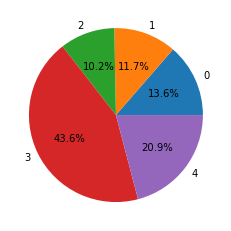

In [30]:
labels = list(set(Ytr))
counts = []
for label in labels:
    counts.append(np.count_nonzero(Ytr == label))
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.show()

các nhãn lớp không được phân phối đồng đều, vì vậy hãy sử dụng SMOT và ghi đè lên các lớp có số lượng ít hơn để các lớp được phân bổ đều

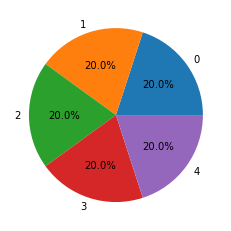

In [31]:
sm = SMOTE(random_state=42)
Xtr, Ytr = sm.fit_sample(Xtr, Ytr)
labels = list(set(Ytr))
counts = []
for label in labels:
    counts.append(np.count_nonzero(Ytr == label))
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.show()

# Đào tạo mô hình
### Mô hình cơ sở
Các tầng phân tầng khác: tạo ra các dự đoán bằng cách tôn trọng tập huấn phân phối lớp.

In [32]:
dc = DummyClassifier(strategy="stratified")
dc.fit(Xtr, Ytr)
pred = dc.predict(Xde)
print(classification_report(Yde, pred, target_names=encoder.classes_))

                    precision    recall  f1-score   support

Business & Finance       0.06      0.09      0.07        81
  Criminal Justice       0.12      0.18      0.14        83
       Health Care       0.12      0.27      0.17        63
 Politics & Policy       0.39      0.19      0.26       232
  Science & Health       0.18      0.14      0.16       135

          accuracy                           0.17       594
         macro avg       0.18      0.17      0.16       594
      weighted avg       0.23      0.17      0.18       594



### Cây quyết định

In [33]:
dt = DecisionTreeClassifier()
dt.fit(Xtr, Ytr)
pred = dt.predict(Xde)
print(classification_report(Yde, pred, target_names=encoder.classes_))

                    precision    recall  f1-score   support

Business & Finance       0.32      0.54      0.40        81
  Criminal Justice       0.38      0.57      0.46        83
       Health Care       0.45      0.60      0.51        63
 Politics & Policy       0.69      0.49      0.57       232
  Science & Health       0.69      0.41      0.52       135

          accuracy                           0.50       594
         macro avg       0.50      0.52      0.49       594
      weighted avg       0.57      0.50      0.51       594



### Rừng ngẫu nhiên 

In [36]:
rf = RandomForestClassifier(n_estimators=40)
rf.fit(Xtr, Ytr)
pred = rf.predict(Xde)
print(classification_report(Yde, pred, target_names=encoder.classes_))

                    precision    recall  f1-score   support

Business & Finance       0.42      0.54      0.48        81
  Criminal Justice       0.42      0.66      0.51        83
       Health Care       0.47      0.78      0.59        63
 Politics & Policy       0.79      0.54      0.64       232
  Science & Health       0.67      0.47      0.55       135

          accuracy                           0.57       594
         macro avg       0.55      0.60      0.55       594
      weighted avg       0.63      0.57      0.57       594



### Đa hình Naive Bayesian

In [37]:
nb = MultinomialNB()
nb.fit(Xtr, Ytr)
pred = nb.predict(Xde)
print(classification_report(Yde, pred, target_names=encoder.classes_))

                    precision    recall  f1-score   support

Business & Finance       0.58      0.56      0.57        81
  Criminal Justice       0.61      0.70      0.65        83
       Health Care       0.44      0.60      0.51        63
 Politics & Policy       0.73      0.66      0.69       232
  Science & Health       0.71      0.64      0.67       135

          accuracy                           0.64       594
         macro avg       0.61      0.63      0.62       594
      weighted avg       0.66      0.64      0.65       594



### Support Vector Classification

In [38]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(Xtr, Ytr)
pred = svc.predict(Xde)
print(classification_report(Yde, pred, target_names=encoder.classes_))

                    precision    recall  f1-score   support

Business & Finance       0.28      0.21      0.24        81
  Criminal Justice       0.59      0.19      0.29        83
       Health Care       0.67      0.32      0.43        63
 Politics & Policy       0.50      0.88      0.64       232
  Science & Health       0.65      0.31      0.42       135

          accuracy                           0.51       594
         macro avg       0.54      0.38      0.40       594
      weighted avg       0.53      0.51      0.46       594



### Multilayered Perceptron

In [39]:
mlp = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(100, 20), random_state=1, max_iter=400)
mlp.fit(Xtr, Ytr)
pred = mlp.predict(Xde)
print(classification_report(Yde, pred, target_names=encoder.classes_))

                    precision    recall  f1-score   support

Business & Finance       0.58      0.52      0.55        81
  Criminal Justice       0.52      0.65      0.58        83
       Health Care       0.39      0.49      0.44        63
 Politics & Policy       0.69      0.68      0.68       232
  Science & Health       0.70      0.56      0.62       135

          accuracy                           0.61       594
         macro avg       0.57      0.58      0.57       594
      weighted avg       0.62      0.61      0.61       594



# Dựa vào thử nghiệm nhiều models => Multinomial Naive Bayesian
**Multinomial Naive Bayesian** làm việc tốt nhất Hãy chạy NB trên dữ liệu thử nghiệm và lấy ma trận hỗn hợp và bản đồ nhiệt của nó.
## Dự đoán dữ liệu kiểm tra

                    precision    recall  f1-score   support

Business & Finance       0.52      0.59      0.55       102
  Criminal Justice       0.58      0.55      0.56       117
       Health Care       0.55      0.72      0.62        81
 Politics & Policy       0.74      0.68      0.71       352
  Science & Health       0.67      0.66      0.67       140

          accuracy                           0.65       792
         macro avg       0.61      0.64      0.62       792
      weighted avg       0.66      0.65      0.65       792



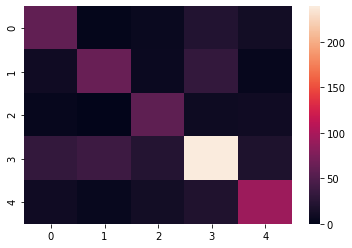

In [40]:
pred = nb.predict(Xte)
print(classification_report(Yte, pred, target_names=encoder.classes_))
sns.heatmap(confusion_matrix(Yte, pred))

In [42]:
nb1 = MultinomialNB()
nb1.fit(Xtr_whole, Ytr_whole)
coefs = nb1.coef_
target_names = encoder.classes_

for i in range(len(target_names)):
    words = []
    for j in coefs[i].argsort()[-20:]:
        words.append(reverse_vocabulary[j])
    print (target_names[i], '-', words, "\n")

Business & Finance - ['people', 'best', 'apple', 'charts', 'money', 'big', 'make', '5', 'chart', 'us', 'one', '000', 'deal', 'explained', 'greece', 'â', 'crisis', 'economy', 'could', 'new'] 

Criminal Justice - ['report', 'jury', 'america', 'black', 'crime', 'rape', 'â', 'brown', 'michael', '5', 'justice', 'darren', 'wilson', 'explained', 'people', 'marijuana', 'one', 'new', 'police', 'ferguson'] 

Health Care - ['â', 'chart', 'cut', 'study', 'percent', 'control', 'insurance', '000', 'medicaid', 'uninsured', 'new', 'people', 'doctors', 'americans', 'could', 'va', 'one', 'care', 'health', 'obamacare'] 

Politics & Policy - ['american', 'people', 'time', 'clinton', 'plan', 'president', 'scott', 'republican', 'walker', 'house', 'health', 'gop', 'new', 'explained', 'big', 'debate', 'â', 'one', 'obamacare', 'obama'] 

Science & Health - ['ebola', 'world', 'wrong', 'explained', 'might', 'study', 'health', 'dr', 'could', 'pluto', 'nasa', 'space', 'year', 'people', 'us', 'one', 'science', 'sci